# Siamese network implementation with the strips dataset

With denoised and averaged images

## Dataset structure

The images themselves are stored already cut as strips, with the characteristic extracted by denoising them and getting the residual, as described in Lukas et al. We have an indexing file to retrieve them (info data) in the following structure:

* Info data:
    * Student 0:
        * Image 0:
            * Strip 0,0
            * Strip 0,256
            * Strip 0,512
            * ...
        * Image 1:
            * Strip 0,0
            * ...
        * ...
    * Student 1:
        * ...

Strip naming convention:

* Eurecom_NNN_picXG_III_XXXX_YYYY.PNG -> Strip from:
    * position (XXXX,YYYY) (top, left), from: 
    * image picXG_III, from:
    * Student with id NNN

Then, the function get_batch generates a random sample from the dataset. It allows to draw either from the training or validation split of the dataset (defined at the level of the students, 0.8 of the students are in train and the rest in validation).
The generated batch has the following shape:

* (label, (batch_size, examples, height, width, channels), (batch_size, examples, height, width, channels))  Since images are grayscale, in fact channels should be 1

More clearly:

* batch:
    * label 0:
        * strip_x-y from Image j from Student i  <---------->  strip_w-t from Image k from Student l
        * strip_x-y from Image j2 from Student i  <---------->  strip_w-t from Image k2 from Student l
        * strip_x-y from Image j3 from Student i  <---------->  strip_w-t from Image k3 from Student l
        * strip_x-y from Image j4 from Student i  <---------->  strip_w-t from Image k4 from Student l
    * label 0:
        * ...
        
    * label 1:
        * strip_x-y from Image j from Student i  <---------->  strip_w-t from Image k from Student i
        * strip_x-y from Image j2 from Student i  <---------->  strip_w-t from Image k2 from Student i
        * strip_x-y from Image j3 from Student i  <---------->  strip_w-t from Image k3 from Student i
        * strip_x-y from Image j4 from Student i  <---------->  strip_w-t from Image k4 from Student i
    * label 1:
        * ...
        
Note that ${i \neq l, j \neq j_i}$ etc. 

            
            

## Training pipeline

During training, a batch is generated at random from the training slice, ensuring the previously described invariant. The next steps are as follows:

* Images are normalized
* We define the left and right input, according to the tuple in the pair (for label == 0, all strips belong to the same camera and position, while for label == 1, each input belongs to a different camera.)
* All images from each input are averaged element-wise (separetely, of course)
* The result is fed, one at a time to a CNN model defined at sequential_block. Note that the weights are the same for each input
* The CNN outputs a feature vector of size 2048
* The output from each of the inputs is compared by calculating the absolute distance between the two vectors
* This result is fed into a final Dense layer, for classification, with sigmoid activation. 
    * A result close to 0 indicates that the strips from each input belong to different devices.
    * A result close to 1 indicates that the strips from each input where taken by the same device.


In [ ]:
!pip install opencv-python

In [1]:
import os
import numpy as np
import random as rng
import cv2
import json

In [2]:
info_data = []
with open('/home/data/strips_socrates/dataset_info.json') as json_file: 
    info_data = json.load(json_file) 

In [3]:
STRIP_SIZE = 256
SUB_STRIP_SIZE = 128
CHANNELS = 3

In [4]:
def get_batch(info_data, batch_size, examples, with_id=False, dataset = 'train'):
    pairs = [np.zeros((batch_size, examples, 128, 128, CHANNELS)) for i in range(2)]
    labels = np.zeros((batch_size, ))
    labels[batch_size//2:] = 1
    split_lhs = 0
    split_rhs = len(info_data)-1
    if dataset == 'train':
        split_rhs = int((len(info_data)-1)*0.55)
    elif dataset == 'validation':
        split_lhs = int((len(info_data)-1)*0.55)+1
        split_rhs = int((len(info_data)-1)*0.62)
    elif dataset == 'test':
        split_lhs = int((len(info_data)-1)*0.62)+1
        split_rhs = int((len(info_data)-1))
    num_stds = split_rhs-split_lhs+1
    students = [rng.randint(split_lhs, split_rhs) for _ in range(batch_size)]
    strips_loc = [rng.randint(0, len(info_data[i][0][1])-1) for i in students]
    id_pairs = []
    for i in range(batch_size):
        std = students[i]
        avl_images = [j for j in range(len(info_data[std]))]
        exl = rng.sample(avl_images, examples)
        avl_images = [j for j in avl_images if j not in exl]
        srl = strips_loc[i]
        strips1 = [ info_data[std][e][1][srl] for e in exl ]
        strips2 = []
        if i >= batch_size // 2:
            exl2 = rng.sample(avl_images, examples)
            strips2 = [info_data[std][e][1][srl] for e in exl2]
        else:
            std2 = split_lhs + (((std-split_lhs) + rng.randint(1, num_stds-1)) % num_stds)
            srl2 = rng.randint(0, len(info_data[std2][0][1])-1)
            avl_images2 = [j for j in range(len(info_data[std2]))]
            exl2 = rng.sample(avl_images2, examples)
            strips2 = [ info_data[std2][e][1][srl2] for e in exl2]
        for k in range(examples):
            rch = rng.randint(0, 127)
            rcw = rng.randint(0, 127)
            im1 = cv2.imread(strips1[k], cv2.IMREAD_UNCHANGED)
            if im1 is None:
                print(f"Error reading {strips1[k]}, dataset:{dataset}")
            im2 = cv2.imread(strips2[k], cv2.IMREAD_UNCHANGED)
            if im2 is None:
                print(f"Error reading {strips2[k]}, dataset:{dataset}")
            pairs[0][i,k,...] = im1[rch:rch+128,rcw:rcw+128,:]/255
            pairs[1][i,k,...] = im2[rch:rch+128,rcw:rcw+128,:]/255
        id_pairs.append((strips1, strips2))
    if with_id:
        return pairs, labels, id_pairs
    else:
        return pairs, labels

In [ ]:
p,l,ids = get_batch(info_data, 10, 4, True, dataset="validation")

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
p[0][0][0].shape

In [ ]:
plt.imshow(p[0][0][0])

In [ ]:
for r,s in zip(l, ids):
    print(r)
    for a in s:
        for b in a:
            print(b)

In [5]:
def generate(info_data, examples, batch_size, dataset='train'):
    while True:
        pairs, labels = get_batch(info_data, batch_size, examples, False, dataset=dataset)
        yield(pairs, labels)

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [7]:
def sequential_block(input_shape = (128,128, 3), base_filters=64):
    model = keras.Sequential()
    model.add(layers.Conv2D(base_filters, (3,3), input_shape=input_shape, activation="relu"))
    #model.add(layers.SpatialDropout2D(0.1))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=1))
    model.add(layers.BatchNormalization(renorm=True))
    model.add(layers.Conv2D(base_filters*2, (3,3) ,activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(layers.BatchNormalization(renorm=True))
    model.add(layers.Conv2D(base_filters*4, (3,3), activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(layers.BatchNormalization(renorm=True))
    model.add(layers.Conv2D(base_filters*4, (3,3), activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(layers.BatchNormalization(renorm=True))
    model.add(layers.Conv2D(base_filters*4, (3,3), activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(layers.BatchNormalization(renorm=True))
    #model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(base_filters*32, activation='relu'))
    
    
    
    return model

In [ ]:
seq = sequential_block(base_filters=32)

In [ ]:
seq.summary()

In [8]:
def get_siamese_model(input_shape = (4, 128,128,3), base_filters=16):

    left_input = layers.Input(input_shape)
    right_input = layers.Input(input_shape)
    
    # Convolutional Neural Network
    subshape = input_shape[1:4]
    model = sequential_block(subshape, base_filters)
    
    #average noise patterns for image examples
    avged_input_l = layers.Average()([left_input[:,k,...] for k in range(input_shape[0])])
    avged_input_r = layers.Average()([right_input[:,k,...] for k in range(input_shape[0])])

    encoded_l = model(avged_input_l)
    encoded_r = model(avged_input_r)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = layers.Dense(1,activation='sigmoid')(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = keras.Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [9]:
model = get_siamese_model(base_filters=32)
model.summary(200)

Model: "model"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                      Output Shape                                Param #                 Connected to                                                      
input_1 (InputLayer)                                              [(None, 4, 128, 128, 3)]                    0                                                                                         
________________________________________________________________________________________________________________________________________________________________________________________________________
input_2 (InputLayer)                                              [(None, 4, 128, 128, 3)]                    0                                                                      

In [10]:
initial_learning_rate = 1e-5
end_learning_rate = 1e-7
decay_steps = 12800 * 5
lr_schedule = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate, decay_steps, end_learning_rate, power=1
)
model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=[keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'), "accuracy"] 
    )
run_name = "rand_crop05"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs/"+run_name)

checkpoint_filepath = "checkPts/siamese_"+run_name+".h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True)

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, verbose=1)

In [11]:
batch_size = 16
epochs = 500
examples = 4
steps_epoch = 128

In [ ]:
val_set = get_batch(info_data, 300, 4, False, 'validation')

In [ ]:
model.fit(generate(info_data, examples, batch_size, dataset='train'), 
         epochs = epochs,
          initial_epoch=9,
         steps_per_epoch= steps_epoch,
          callbacks=[tensorboard_callback,
                     model_checkpoint_callback,
                     early_stopping_callback],
          validation_batch_size=16,
          validation_data=val_set,
         shuffle = True)

In [ ]:
model.save("last-hack02.h5")

In [11]:
model.load_weights("checkPts/siamese_rand_crop05.h5") #best model so far

### Validation:
Simple, just feed pairs from the validation split and see the performance.

In [25]:
val_set = get_batch(info_data, 1, 4, False, 'whole')

In [18]:
preds = model.predict(val_set[0])

In [19]:
corr = [y == (p>0) for y, p in zip (val_set, preds)]

In [ ]:
round(preds[0][0])

In [ ]:
cs = np.zeros((2,2))
for y,p in zip (val_set[1], preds):
    cs[int(y), round(p[0])] += 1 
acc = (cs[0,0] + cs [1 , 1]) / np.sum(cs)
rec = cs[1,1] / np.sum(cs[1])
print(cs, acc, rec)

# Extended validation: 
Take two images, and compare strip by strip, then do a majority voting.

In [23]:
def predict_extended(model, info_data, std1, std2, ims1, ims2, max_test_per_pair):
    examples = len(ims1)
    pair = [np.zeros((1, examples, 128, 128, CHANNELS)) for i in range(2)]
    nstrips1 = len(info_data[std1][0][1])
    nstrips2 = len(info_data[std2][0][1])
        
    all_strips1 = [[info_data[std1][im][1][i] for im in ims1] for i in range(nstrips1)]
    all_strips2 = [[info_data[std2][im][1][i] for im in ims2] for i in range(nstrips2)]
    
    predicts = []
    mt = [0]*max_test_per_pair
    for strips1, strips2, _ in zip(all_strips1, all_strips2, mt):    
        for k in range(examples):
            s1 = strips1[k]
            s2 = strips2[k]
            im1 = cv2.imread(s1)[64:256-64, 64:256-64,:]
            im2 = cv2.imread(s2)[64:256-64, 64:256-64,:]
            if im1 is None:
                print(f"Error reading {strips1[k]}, dataset:{dataset}")
            if im2 is None:
                print(f"Error reading {strips2[k]}, dataset:{dataset}")
            pair[0][0, k,:,:,:] = im1/255
            pair[1][0, k,:,:,:] = im2/255
        predicts.append(model.predict(pair))
    return predicts

In [42]:
def test_extended(model, info_data, max_pairs, max_test_per_pair,  examples, dataset, thr):
    split_lhs = 0
    split_rhs = len(info_data)-1
    if dataset == 'train':
        split_rhs = int((len(info_data)-1)*0.52)
    elif dataset == 'validation':
        split_lhs = int((len(info_data)-1)*0.52)+1
        split_rhs = int((len(info_data)-1)*0.61)
    elif dataset == 'test':
        split_lhs = int((len(info_data)-1)*0.61)+1
        split_rhs = int((len(info_data)-1))
    num_stds = split_rhs-split_lhs+1
    students = [rng.randint(split_lhs, split_rhs) for _ in range(max_pairs)]
    cs = np.zeros((2,2))
    all_preds = [(0,0)]*max_pairs
    progress = int (max_pairs * 0.1)
    for i in range(max_pairs):
        if i % progress == 0:
            print(f'Progress: {i} of {max_pairs}')
        std = students[i]
        avl_images = [j for j in range(len(info_data[std]))]
        exl = rng.sample(avl_images, examples)
        avl_images = [j for j in avl_images if j not in exl]
        if i >= max_pairs // 2:
            exl2 = rng.sample(avl_images, examples)
            preds = predict_extended(model, info_data, std, std, exl, exl2, max_test_per_pair)
            score = sum(preds)/len(preds)
            all_preds[i] = (1,score)
            cs[1][int(score>thr)] += 1
        else:
            std2 = split_lhs + (((std-split_lhs) + rng.randint(1, num_stds-1)) % num_stds)
            avl_images2 = [j for j in range(len(info_data[std2]))]
            exl2 = rng.sample(avl_images2, examples)
            preds = predict_extended(model, info_data, std, std2, exl, exl2, max_test_per_pair)
            score = sum(preds)/len(preds)
            all_preds[i] = (0,score)
            cs[0][int(score>thr)] += 1
    return all_preds, cs

# Final testing, with test (unseen until now) set
Note that I'm using 'whole' to have no split, but this is because the training and validation sets have been deleted from the system to make space for the test set. Thus all images from the following test belong to devices unseen before this point. 

In [43]:
preds, cs = test_extended(model, info_data, 1000, 40, 4, 'whole', 0.3 )

Progress: 0 of 1000
Progress: 100 of 1000
Progress: 200 of 1000
Progress: 300 of 1000
Progress: 400 of 1000
Progress: 500 of 1000
Progress: 600 of 1000
Progress: 700 of 1000
Progress: 800 of 1000
Progress: 900 of 1000


In [44]:
y_true = [p[0] for p in preds]
y_pred = [p[1].flatten() for p in preds]

In [45]:
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [46]:
def conf_mat(y_true, y_pred, thr):
    cm = np.zeros((2,2))
    for yt, yp in zip(y_true,y_pred):
        cm[yt][int(yp>thr)] +=1
    return cm

In [57]:
conf_mat(y_true,y_pred, 0.42)

array([[429.,  71.],
       [ 65., 435.]])

In [48]:
roc_auc =roc_auc_score(y_true, y_pred)

In [49]:
fpr, tpr, thrs = roc_curve(y_true, y_pred)

In [50]:
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thrs)(eer)


In [51]:
eer

0.1360000000005653

In [52]:
roc_auc

0.944748

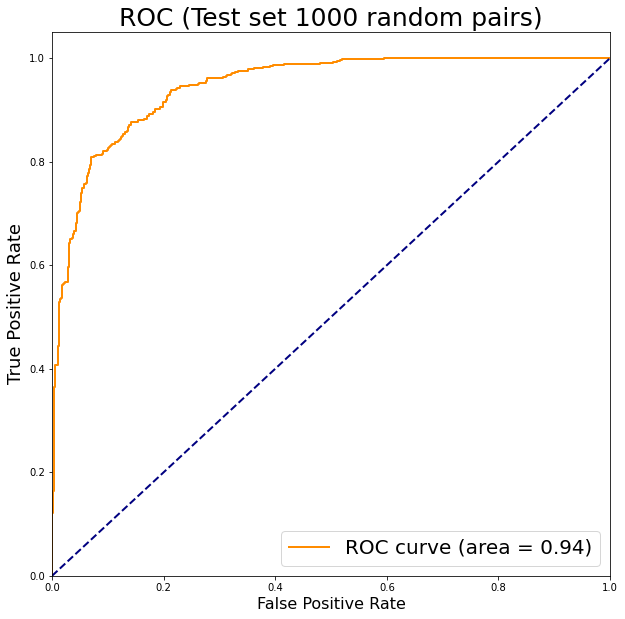

In [53]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC (Test set 1000 random pairs)', fontsize=25)
plt.legend(loc="lower right", fontsize=20)
plt.show()